In [9]:
import time
import argparse
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML

# Configuration
class Cfg:
    matchings = ['assignments_max_4_5.json', 'assignments_q_0.75_4_5.json']
    root_dir = './data/'

In [10]:
def parse_matchings_file(matchings_path):
    with open(matchings_path, 'r') as file:
        matchings = json.load(file)
    return matchings

def matchings_to_scores_df(matchings):
    """Returns a dataframe with schema {'paper_id': 'str', 'scores': List[float]}"""
    paper_to_scores = {}
    for paper_id in matchings:
        # Note: Some papers have an ID of 0 for some reason?
        # if paper_id == '0' or paper_id == 0:
        #     print(matchings[paper_id])
        for match in matchings[paper_id]:
            if paper_id not in paper_to_scores:
                paper_to_scores[paper_id] = []
            paper_to_scores[paper_id].append(match['aggregate_score'])
    df = pd.DataFrame({'paper_id': list(paper_to_scores.keys()),
                       'scores': list(paper_to_scores.values())})
    return df

def matchings_to_load_df(matchings):
    """Returns a dataframe with schema {'reviewer_id': 'str', 'paper_info': [(paper_id, score), ...]]}.
    Indices of paper_ids and papers_scores correspond to each other."""
    # reviewer_id -> [(paper_id, score), ...]
    reviewer_to_papers = {}
    for paper_id in matchings:
        for match in matchings[paper_id]:
            reviewer = match['user']
            score = match['aggregate_score']
            val = reviewer_to_papers.get(reviewer, [])
            val.append((paper_id, score))
            reviewer_to_papers[reviewer] = val
    df = pd.DataFrame({'reviewer_id': list(reviewer_to_papers.keys()),
                       'paper_info': list(reviewer_to_papers.values())})
    return df

In [3]:
# paper_id: [{'aggregate_score': float, 'user': str}, ...]
all_matchings = {fname: {'matchings': parse_matchings_file(os.path.join(Cfg.root_dir, fname))} for fname in Cfg.matchings}

# General Score Statistics

- Mean score per paper and its standard deviation.
- Lowest 5% quantile score

Matchings: assignments_max_4_5.json


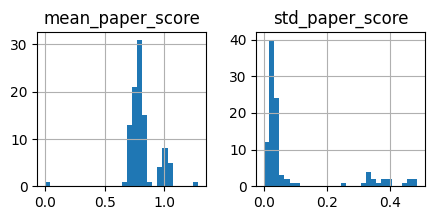

Matchings: assignments_q_0.75_4_5.json


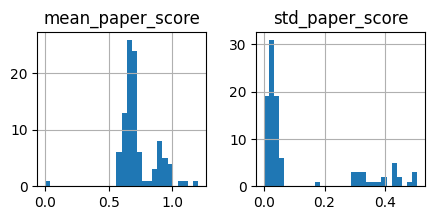

In [4]:
def plot_score_distr(df):   
    df['mean_paper_score'] = df['scores'].apply(lambda x: np.mean(x))
    df['std_paper_score'] = df['scores'].apply(lambda x: np.std(x))
    fig, axs = plt.subplots(1, 2, figsize=(5, 2))
    df.hist(column='mean_paper_score', bins=30, ax=axs[0])
    df.hist(column='std_paper_score', bins=30, ax=axs[1]);
    plt.show()

for matching_name, info in all_matchings.items():
    print("Matchings:", matching_name)
    matchings = info['matchings']
    scores_df = matchings_to_scores_df(matchings)
    all_matchings[matching_name]['scores_df'] = scores_df
    plot_score_distr(scores_df)


In [5]:
def quantile_report(df, quantile, column='mean_paper_score'):
    lowq_mean_score = df[column].quantile(quantile)
    highq_mean_score = df[column].quantile(1-quantile)
    return lowq_mean_score, highq_mean_score


quantile = 0.05
for matching_name, info in all_matchings.items():
    scores_df = info['scores_df']
    low_score, high_score = quantile_report(scores_df, quantile)
    # Not strict inequalities;
    low_count = len(scores_df[scores_df['mean_paper_score'] >= low_score])
    high_count = len(scores_df[scores_df['mean_paper_score'] >= high_score])
    print(matching_name, f"\n\t{(1 - quantile) * 100:.0f}% of assignments have a score >= {low_score:.2f} (count {low_count}).",
         f"\n\tThe top {(quantile) * 100:.0f}% assignments have a score >= {high_score:.2f} (count {high_count}).")

assignments_max_4_5.json 
	95% of assignments have a score >= 0.69 (count 96). 
	The top 5% assignments have a score >= 1.03 (count 6).
assignments_q_0.75_4_5.json 
	95% of assignments have a score >= 0.59 (count 96). 
	The top 5% assignments have a score >= 0.97 (count 6).


# Inspecting Tail Scores

For tail papers, check if
1. If there are outlier reviewers; one or more reviewers with a particularly low scores and flag them.
2. If there are no high-affinity reviewers for some papers, flag them.

In [11]:
# Note: Manually selected looking at the distribution of std deviations.
max_std = 0.10
for matching_name, info in all_matchings.items():
    df = info['scores_df']
    low_score, high_score = quantile_report(df, quantile)
    low_df = df[df['mean_paper_score'] <= low_score]
    e_df = low_df[low_df['std_paper_score'] > max_std].copy()
    print(matching_name)
    # Are these papers low tail because some of the reviewrs have low scores?
    if len(e_df) == 0:
        print(f"\tTest 1: There are no reviewers with low relative affinity score (score <= mean - std, std: {max_std})")
    else:
        # 1-std away from mean. 
        e_df['outlier_scores'] = e_df['scores'].apply(lambda scores: [x for x in scores if x < np.mean(scores) - max_std])
        display(e_df)
    # Do all the reviewers have low score? Then the quality of overall reviews might be low.
    f_df = low_df[low_df['std_paper_score'] < max_std].copy()
    if len(f_df) > 0:
        print("\tTest 2: All the reviewers have low individual scores." +
                  f"There are no 'high-affinity' reviewers. (std: {max_std})")
        display(f_df)
    else:
        print("\tTest 2: There is at least one high affinity reviewer")
    display(HTML('<hr>'))

assignments_max_4_5.json
	Test 1: There are no reviewers with low relative affinity score (score <= mean - std, std: 0.1)
	Test 2: All the reviewers have low individual scores.There are no 'high-affinity' reviewers. (std: 0.1)


,paper_id,scores,mean_paper_score,std_paper_score
0,0,"[0.0, 0.0, 0.0, 0.0]",0.000000,0.000000
41,QZ1DVzr6N9,"[0.6976308822631836, 0.6638725996017456, 0.681...",0.690998,0.021015
42,Ri9Hgkvlys,"[0.735435962677002, 0.6578973531723022, 0.6768...",0.677567,0.035863
50,WxFJSyoj4m,"[0.6610082983970642, 0.7004783749580383, 0.663...",0.686820,0.025996
92,vBJZ93tvoE,"[0.6999770998954773, 0.6533613204956055, 0.750...",0.691448,0.038208
95,x7zpwGCE5v,"[0.65937739610672, 0.6920580863952637, 0.63643...",0.688231,0.048560


assignments_q_0.75_4_5.json
	Test 1: There are no reviewers with low relative affinity score (score <= mean - std, std: 0.1)
	Test 2: All the reviewers have low individual scores.There are no 'high-affinity' reviewers. (std: 0.1)


,paper_id,scores,mean_paper_score,std_paper_score
0,0,"[0.0, 0.0, 0.0, 0.0]",0.000000,0.000000
11,8QJSTDII5d,"[0.6037047753731409, 0.6070873379707337, 0.565...",0.589641,0.016829
41,QZ1DVzr6N9,"[0.577831506729126, 0.6349323034286499, 0.5708...",0.588908,0.026703
42,Ri9Hgkvlys,"[0.5600370168685913, 0.6175651550292969, 0.635...",0.588729,0.038835
76,kyWZXZ5ZHd,"[0.5706658363342285, 0.5897578994433085, 0.626...",0.588686,0.023565
90,u3iXuPfOVb,"[0.5684395208954811, 0.6041942238807678, 0.580...",0.592194,0.018855


# General Reviewer Load 

assignments_max_4_5.json
assignments_q_0.75_4_5.json


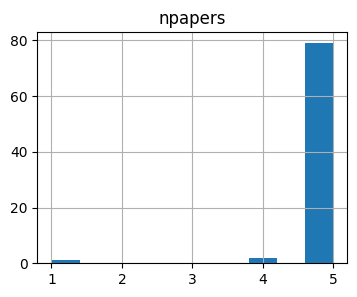

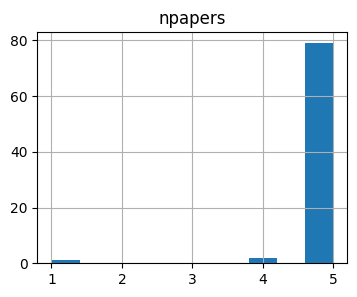

In [7]:
for matching_name, info in all_matchings.items():
    print(matching_name)
    matchings = info['matchings']
    load_df = matchings_to_load_df(matchings)
    load_df['npapers'] = load_df['paper_info'].apply(lambda x: len(x))
    load_df.hist(column='npapers', figsize=(4,3))
    info['load_df'] = load_df
    all_matchings[matching_name] = info